### Imports

In [27]:
# Import necessary libraries
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS, add_constant
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

### Import data

In [28]:
# Load dataset
df = pd.read_csv('../../data/data.csv')

# Separate features and target variable
X = df.drop(columns=['Country', 'Region', 'Year', 'Life_expectancy'])
y = df['Life_expectancy']

# Apply Box-Cox transformation to the target (Life Expectancy)
# Box-Cox only accepts positive values, which are satisfied in life expectancy data
y_boxcox, lambda_val = boxcox(y)  # Store the lambda value for inverse transformation later if needed


# Updated feature matrix (X) and transformed target (y_boxcox)
X_transformed = X
y_transformed = pd.Series(y_boxcox, name="Life_expectancy_BoxCox")

# Save column names for reference after train/test split
feature_names = X_transformed.columns.tolist()

# Split the dataset into training and testing sets
X_train_original, X_test_original, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size=0.2, random_state=42)

y_train.reset_index(drop=True, inplace=True)

# Scale the features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_original)
X_test_scaled = scaler_X.transform(X_test_original)

# Convert scaled arrays back to DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test = pd.DataFrame(X_test_scaled, columns=feature_names)

# Perform the Sequential Feature Selection (SFS) and calculations
# Redefine y_train as a DataFrame to match the expected input in OLS if it's not one already
y_train = pd.DataFrame(y_train)

In [29]:
X.head()

,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,Polio,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status_Developed,Economy_status_Developing
0,11.1,13.0,105.8240,1.32,97,65,27.8,97,97,0.08,11006,78.53,4.9,4.8,7.8,0,1
1,2.7,3.3,57.9025,10.35,97,94,26.0,97,97,0.09,25742,46.44,0.6,0.5,9.7,1,0
2,51.5,67.9,201.0765,1.57,60,35,21.2,67,64,0.13,1076,1183.21,27.1,28.0,5.0,0,1
3,32.8,40.5,222.1965,5.68,93,74,25.3,92,93,0.79,4146,0.75,5.7,5.5,7.9,0,1
4,3.4,4.3,57.9510,2.89,97,89,27.0,94,94,0.08,33995,7.91,1.2,1.1,12.8,1,0


## Feature selection

### _Checking regression model accuracy metrics for optimal numbers of features_

Using a Sequential forward selection to find the best subsets both on the transformed data and the original data

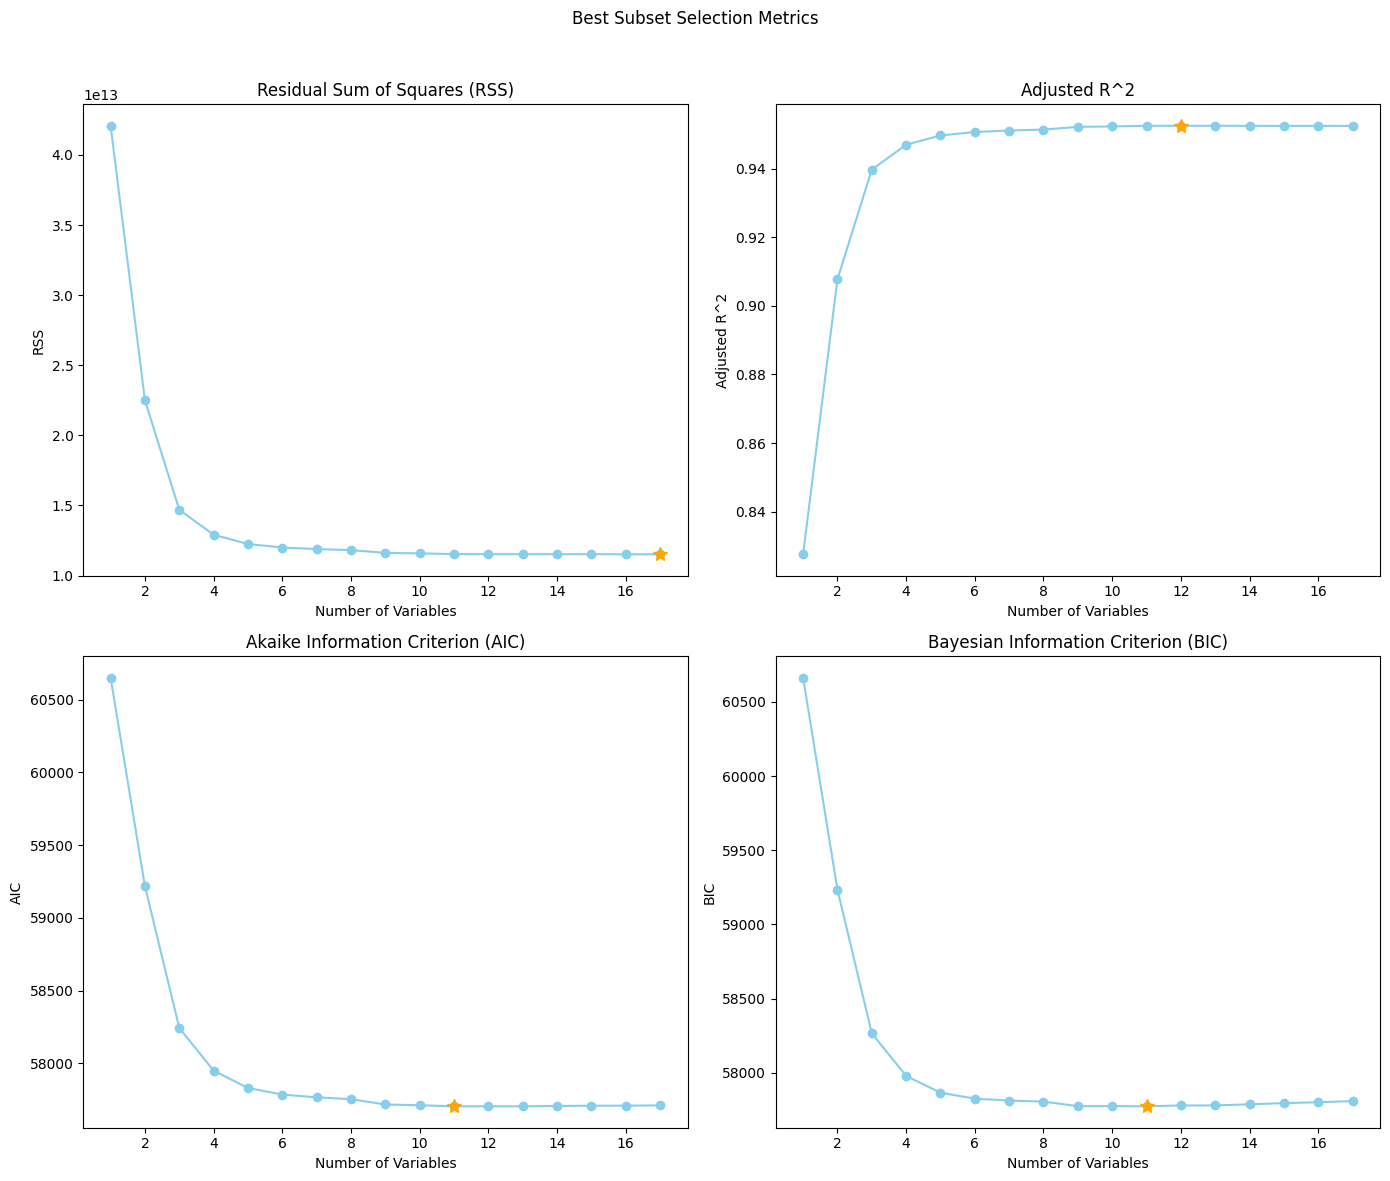

In [30]:
# Define the regression model
model = LinearRegression()

# Sequential feature selection to find best subsets up to all features
sfs_reg = SFS(model,
          k_features=(1, X_train.shape[1]),  # Test from 1 feature up to all features
          forward=True,
          floating=False,
          scoring='r2',
          cv=5)

# Fit SFS on the transformed data
sfs_reg = sfs_reg.fit(X_train, y_train)

# Get the selection results for each subset size
results = sfs_reg.subsets_

# Initialize lists to store metrics for each subset size
rss_list = []
adj_r2_list = []
aic_list = []
bic_list = []
cp_list = []

# Total number of observations
n = X_train.shape[0]

# Calculate metrics for each subset
for subset_size in range(1, X_train.shape[1] + 1):
    # Extract selected feature indices for the current subset size
    selected_features_rg = list(results[subset_size]['feature_idx'])
    X_subset_rg = X_train.iloc[:, selected_features_rg]
    
    # Add a constant term for OLS regression
    X_subset_const_rg = add_constant(X_subset_rg)
    
    # Fit an OLS model and gather stats
    ols_model = OLS(y_train, X_subset_const_rg).fit()
    
    # Residual Sum of Squares (RSS)
    rss = ((ols_model.resid) ** 2).sum()
    rss_list.append(rss)
    
    # Adjusted R^2
    adj_r2_list.append(ols_model.rsquared_adj)
    
    # Akaike Information Criterion (AIC)
    aic_list.append(ols_model.aic)
    
    # Bayesian Information Criterion (BIC)
    bic_list.append(ols_model.bic)
    
    # Mallows' Cp
    mse_full = rss / (n - subset_size - 1)  # Mean squared error
    cp = rss / mse_full - (n - 2 * subset_size)
    cp_list.append(cp)

# Plotting metrics to find optimal subset size
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Best Subset Selection Metrics')

# Define a unified color for all plots
plot_color = 'skyblue'

# Plot RSS
axes[0, 0].plot(range(1, X_train.shape[1] + 1), rss_list, marker='o', color=plot_color)
axes[0, 0].set_xlabel('Number of Variables')
axes[0, 0].set_ylabel('RSS')
axes[0, 0].set_title('Residual Sum of Squares (RSS)')
axes[0, 0].plot(len(rss_list), rss_list[-1], marker='*', markersize=10, color="orange")  # Mark minimum RSS point

# Plot Adjusted R^2
axes[0, 1].plot(range(1, X_train.shape[1] + 1), adj_r2_list, marker='o', color=plot_color)
axes[0, 1].set_xlabel('Number of Variables')
axes[0, 1].set_ylabel('Adjusted R^2')
axes[0, 1].set_title('Adjusted R^2')
max_adjr2_idx = np.argmax(adj_r2_list) + 1
axes[0, 1].plot(max_adjr2_idx, adj_r2_list[max_adjr2_idx - 1], marker='*', markersize=10, color="orange")  # Mark max Adjusted R² point

# Plot AIC
axes[1, 0].plot(range(1, X_train.shape[1] + 1), aic_list, marker='o', color=plot_color)
axes[1, 0].set_xlabel('Number of Variables')
axes[1, 0].set_ylabel('AIC')
axes[1, 0].set_title('Akaike Information Criterion (AIC)')
min_aic_idx = np.argmin(aic_list) + 1
axes[1, 0].plot(min_aic_idx, aic_list[min_aic_idx - 1], marker='*', markersize=10, color="orange")  # Mark minimum AIC point

# Plot BIC
axes[1, 1].plot(range(1, X_train.shape[1] + 1), bic_list, marker='o', color=plot_color)
axes[1, 1].set_xlabel('Number of Variables')
axes[1, 1].set_ylabel('BIC')
axes[1, 1].set_title('Bayesian Information Criterion (BIC)')
min_bic_idx = np.argmin(bic_list) + 1
axes[1, 1].plot(min_bic_idx, bic_list[min_bic_idx - 1], marker='*', markersize=10, color="orange")  # Mark minimum BIC point

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### _Forward selection_

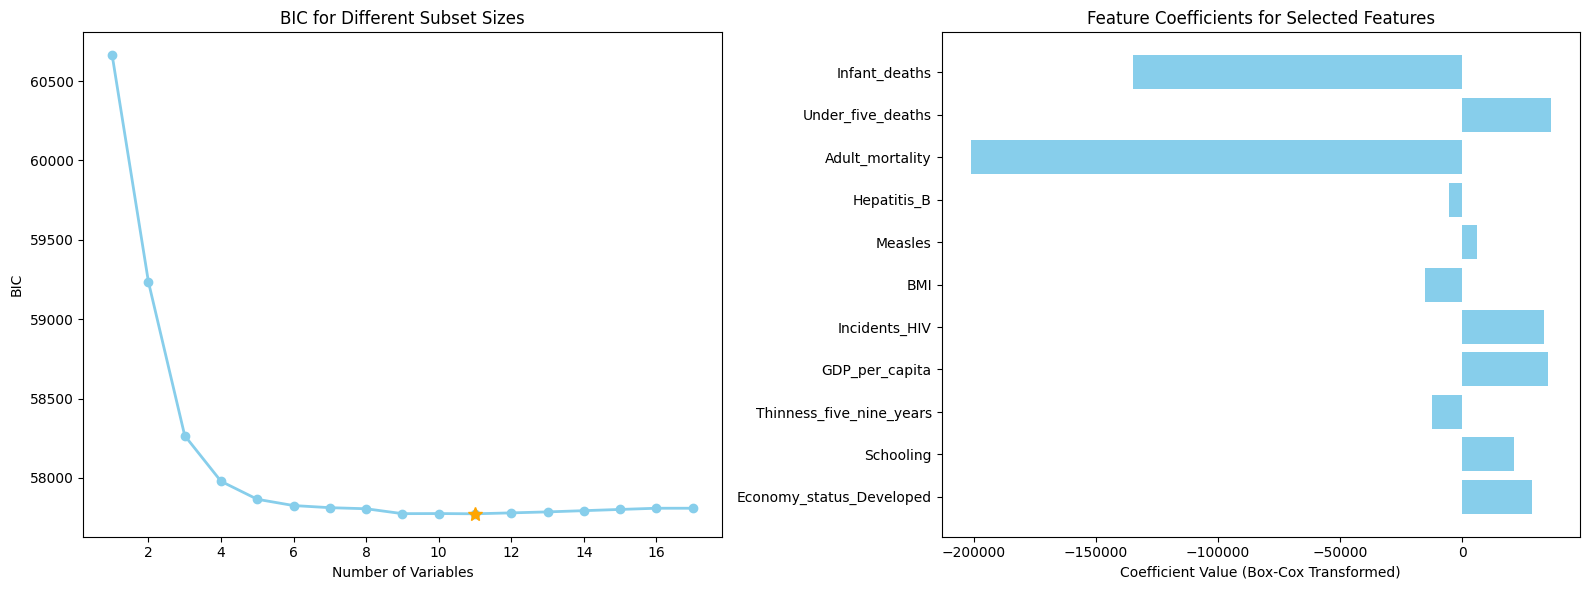

In [31]:
# Step 1: Forward Selection for Subset Selection with transformed data
model = LinearRegression()
sfs_fw = SFS(model,
          k_features=(1, X_train.shape[1]),  # Test from 1 feature up to max features
          forward=True,
          floating=False,
          scoring='r2',
          cv=0)  # Setting cv=0 to get direct estimates without cross-validation for BIC

sfs_fw = sfs_fw.fit(X_train, y_train)

# Step 2: Calculating BIC for each subset with transformed data
bic_list = []
n = len(y_train)

for subset_size in range(1, X_train.shape[1] + 1):  # Loop through all possible subset sizes
    selected_features = list(sfs_fw.subsets_[subset_size]['feature_idx'])  # Get the selected features for each subset size
    X_subset = X_train.iloc[:, selected_features]
    
    # Add constant term to the subset (for intercept)
    X_subset_const = add_constant(X_subset)
    
    # Fit OLS model and calculate BIC
    ols_model = OLS(y_train, X_subset_const).fit()
    bic_list.append(ols_model.bic)
    
# Step 3: Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot BIC on the first subplot
ax1.plot(range(1, X_train.shape[1] + 1), bic_list, marker='o', linestyle='-', color='skyblue', label='BIC', linewidth=2)
ax1.set_xlabel('Number of Variables')
ax1.set_ylabel('BIC')
ax1.set_title('BIC for Different Subset Sizes')

# Mark the minimum BIC point
min_bic_idx = np.argmin(bic_list) + 1  # Index of minimum BIC
ax1.plot(min_bic_idx, bic_list[min_bic_idx - 1], marker='*', markersize=10, color="orange", linewidth=2)  # Marking minimum BIC point in red

# Step 4: Refit the model on the optimal subset using the original target y
optimal_features_tr_fw = list(sfs_fw.subsets_[min_bic_idx]['feature_idx'])  # Get indices of optimal features
optimal_feature_names = [feature_names[i] for i in optimal_features_tr_fw]  # Get names of these features

# Re-fit on the original target variable y for interpretability
X_optimal = X_train.iloc[:, optimal_features_tr_fw]  # Optimal features from training set
X_optimal_df = pd.DataFrame(X_optimal, columns=optimal_feature_names)  # Convert to DataFrame for easier plotting
model.fit(X_optimal_df, y_train)
#coefficients = model.coef_

# Ensure coefficients is a 1D array
coefficients = model.coef_.flatten() if len(model.coef_.shape) > 1 else model.coef_

# Check if the shapes match
assert len(coefficients) == len(optimal_feature_names), "Shape mismatch between feature names and coefficients"


# Plotting the coefficients
ax2.barh(optimal_feature_names, coefficients, color='skyblue')
ax2.set_xlabel('Coefficient Value (Box-Cox Transformed)')
ax2.set_title('Feature Coefficients for Selected Features')
ax2.invert_yaxis()  # Reverse order to have the first selected feature on top

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### _Backward Selection_

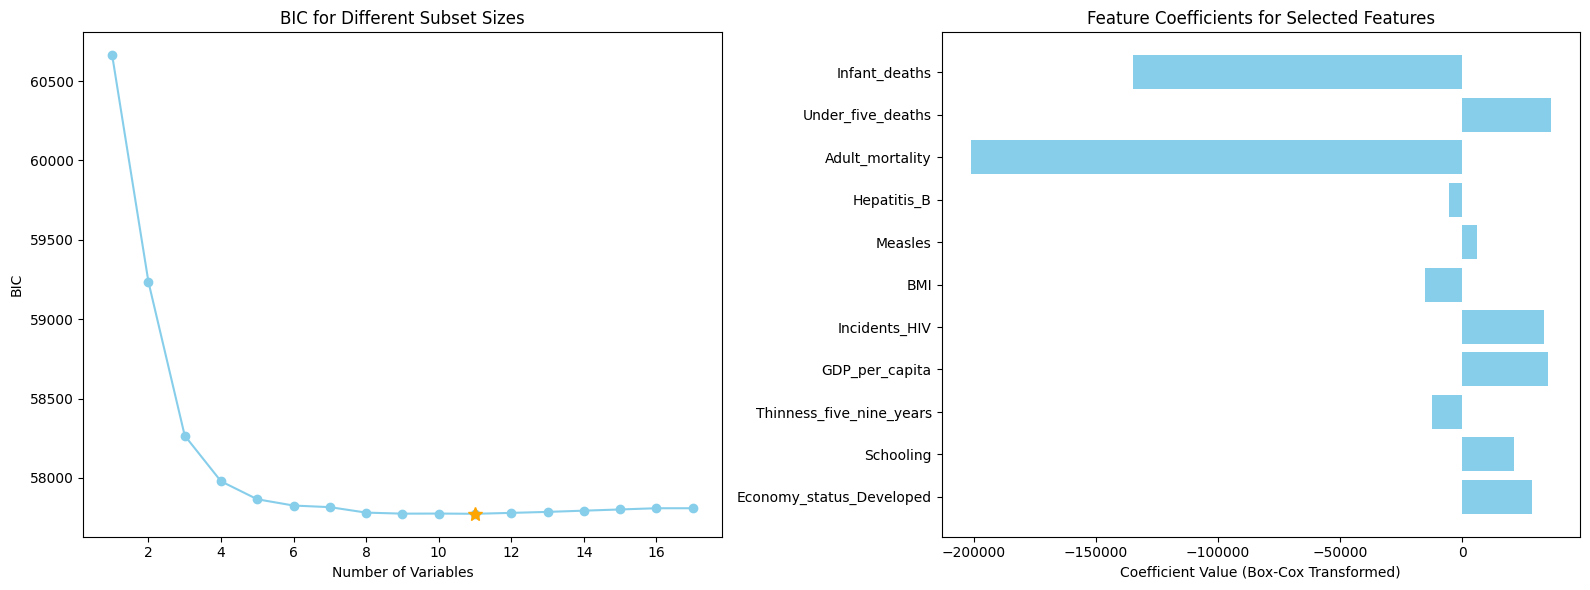

In [32]:
# Step 1: Forward Selection for Subset Selection with transformed data
model = LinearRegression()
sfs_bw = SFS(model,
          k_features=(1, X_train.shape[1]),  # Test from 1 feature up to max features
          forward=False,
          floating=False,
          scoring='r2',
          cv=0)  # Setting cv=0 to get direct estimates without cross-validation for BIC

sfs_bw = sfs_bw.fit(X_train, y_train)

# Step 2: Calculating BIC for each subset with transformed data
bic_list = []
n = len(y_train)

for subset_size in range(1, X_train.shape[1] + 1):  # Loop through all possible subset sizes
    selected_features = list(sfs_bw.subsets_[subset_size]['feature_idx'])  # Get the selected features for each subset size
    X_subset = X_train.iloc[:, selected_features]
    
    # Add constant term to the subset (for intercept)
    X_subset_const = add_constant(X_subset)
    
    # Fit OLS model and calculate BIC
    ols_model = OLS(y_train, X_subset_const).fit()
    bic_list.append(ols_model.bic)
    
# Step 3: Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot BIC on the first subplot
ax1.plot(range(1, X_train.shape[1] + 1), bic_list, marker='o', linestyle='-', color='skyblue', label='BIC')
ax1.set_xlabel('Number of Variables')
ax1.set_ylabel('BIC')
ax1.set_title('BIC for Different Subset Sizes')

# Mark the minimum BIC point
min_bic_idx = np.argmin(bic_list) + 1  # Index of minimum BIC
ax1.plot(min_bic_idx, bic_list[min_bic_idx - 1], marker='*', markersize=10, color="orange")  # Marking minimum BIC point in red

# Step 4: Refit the model on the optimal subset using the original target y
optimal_features_tr_bw = list(sfs_bw.subsets_[min_bic_idx]['feature_idx'])  # Get indices of optimal features
optimal_feature_names = [feature_names[i] for i in optimal_features_tr_bw]  # Get names of these features

# Re-fit on the original target variable y for interpretability
X_optimal = X_train.iloc[:, optimal_features_tr_bw]  # Optimal features from training set
X_optimal_df = pd.DataFrame(X_optimal, columns=optimal_feature_names)  # Convert to DataFrame for easier plotting
model.fit(X_optimal_df, y_train)
# coefficients = model.coef_

# Ensure coefficients is a 1D array
coefficients = model.coef_.flatten() if len(model.coef_.shape) > 1 else model.coef_

# Check if the shapes match
assert len(coefficients) == len(optimal_feature_names), "Shape mismatch between feature names and coefficients"


# Plotting the coefficients
ax2.barh(optimal_feature_names, coefficients, color='skyblue')
ax2.set_xlabel('Coefficient Value (Box-Cox Transformed)')
ax2.set_title('Feature Coefficients for Selected Features')
ax2.invert_yaxis()  # Reverse order to have the first selected feature on top

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Original Data

### _Import Data_

In [33]:
df = pd.read_csv('../../data/data.csv')

X_og = df.drop(columns=['Country', 'Region', 'Year', 'Life_expectancy'])
y_og = df['Life_expectancy']


# scale the features
scaler_X = StandardScaler()
X_og_scaled = scaler_X.fit_transform(X_og)

# convert scaled arrays back to DataFrame
X_og = pd.DataFrame(X_og_scaled, columns=feature_names)


X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(X_og, y_og, test_size=0.2, random_state=42)

### _Checking regression model accuracy metrics for optimal numbers of features_

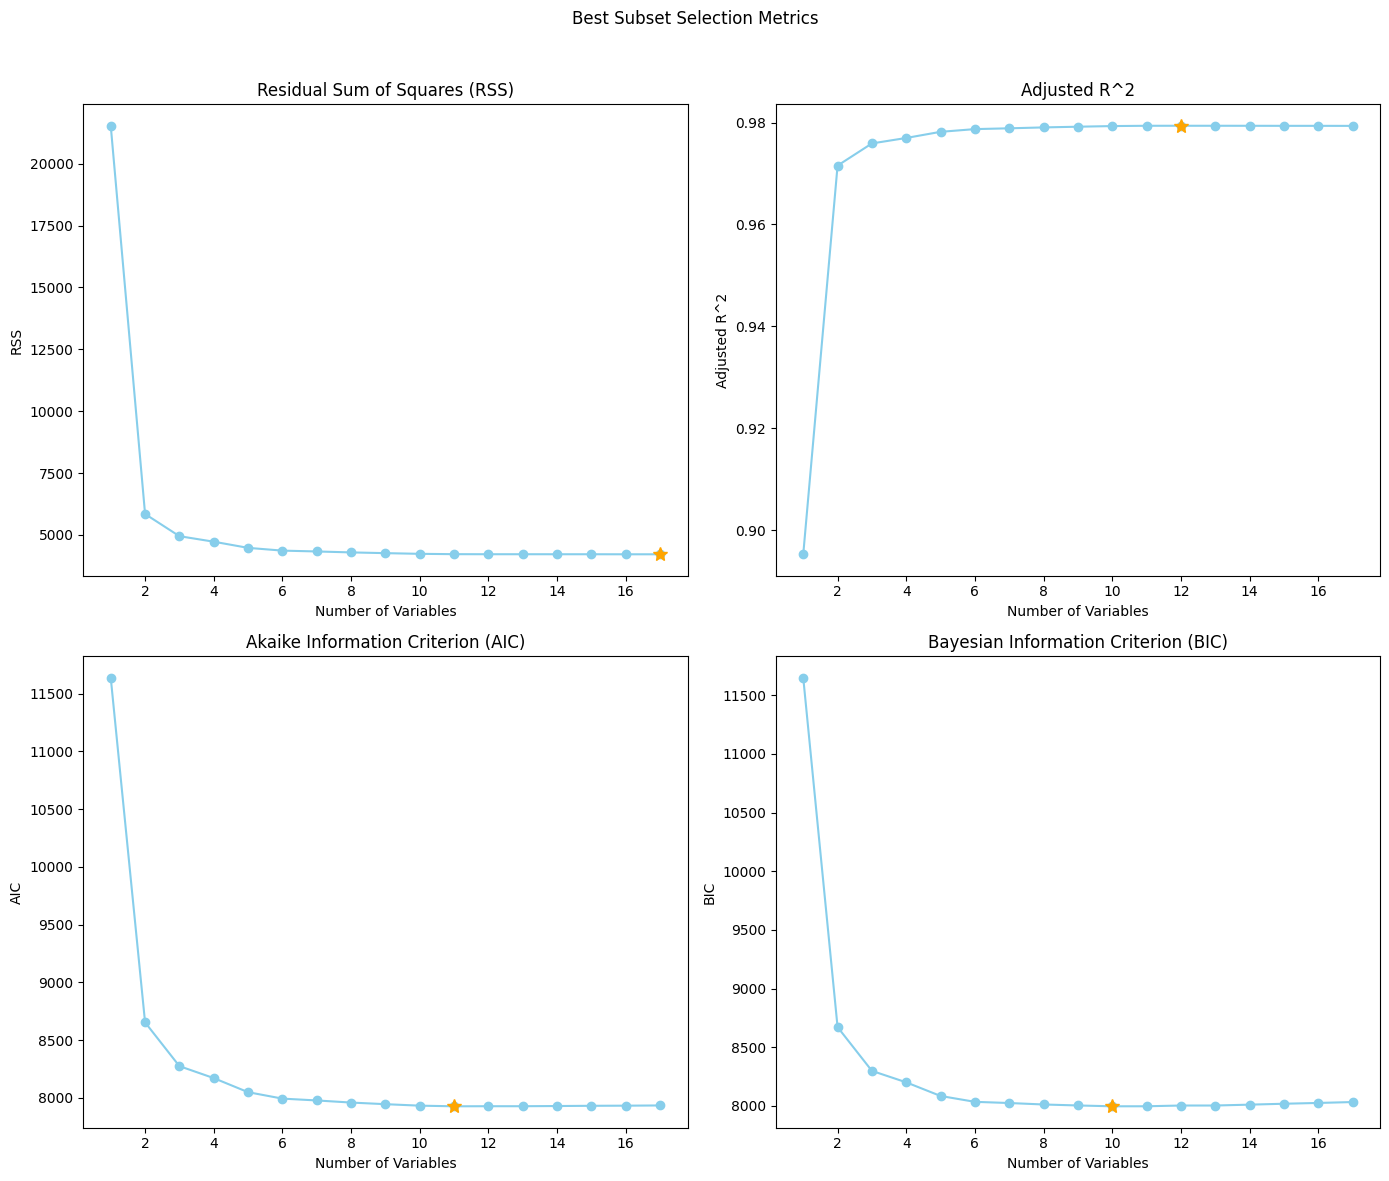

In [34]:
# Define the regression model
model = LinearRegression()

# Sequential feature selection to find best subsets up to all features
sfs = SFS(model,
          k_features=(1, X_train_og.shape[1]),  # Test from 1 feature up to all features
          forward=True,
          floating=False,
          scoring='r2',
          cv=5)

# Fit SFS on the data
sfs = sfs.fit(X_train_og, y_train_og)

# Get the selection results for each subset size
results = sfs.subsets_

# Ensure X is a NumPy array
X_train_og = np.array(X_train_og)

# Initialize lists to store metrics for each subset size
rss_list = []
adj_r2_list = []
aic_list = []
bic_list = []
cp_list = []

# Total number of observations
n = X_train_og.shape[0]

# Calculate metrics for each subset
for subset_size in range(1, X_train_og.shape[1] + 1):
    # Extract selected feature indices for the current subset size
    selected_features = list(results[subset_size]['feature_idx'])
    X_subset = X_train_og[:, selected_features]
    
    # Add a constant term for OLS regression
    X_subset_const = add_constant   (X_subset)
    
    # Fit an OLS model and gather stats
    ols_model = OLS(y_train_og, X_subset_const).fit()
    
    # Residual Sum of Squares (RSS)
    rss = ((ols_model.resid) ** 2).sum()
    rss_list.append(rss)
    
    # Adjusted R^2
    adj_r2_list.append(ols_model.rsquared_adj)
    
    # Akaike Information Criterion (AIC)
    aic_list.append(ols_model.aic)
    
    # Bayesian Information Criterion (BIC)
    bic_list.append(ols_model.bic)
    
    # Mallows' Cp
    mse_full = rss / (n - subset_size - 1)  # Mean squared error
    cp = rss / mse_full - (n - 2 * subset_size)
    cp_list.append(cp)

# Plotting metrics to find optimal subset size
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Best Subset Selection Metrics')

# Define a unified color for all plots
plot_color = 'skyblue'

# Plot RSS
axes[0, 0].plot(range(1, X_train_og.shape[1] + 1), rss_list, marker='o', color=plot_color)
axes[0, 0].set_xlabel('Number of Variables')
axes[0, 0].set_ylabel('RSS')
axes[0, 0].set_title('Residual Sum of Squares (RSS)')
axes[0, 0].plot(len(rss_list), rss_list[-1], marker='*', markersize=10, color="orange")  # Mark minimum RSS point

# Plot Adjusted R^2
axes[0, 1].plot(range(1, X_train_og.shape[1] + 1), adj_r2_list, marker='o', color=plot_color)
axes[0, 1].set_xlabel('Number of Variables')
axes[0, 1].set_ylabel('Adjusted R^2')
axes[0, 1].set_title('Adjusted R^2')
max_adjr2_idx = np.argmax(adj_r2_list) + 1
axes[0, 1].plot(max_adjr2_idx, adj_r2_list[max_adjr2_idx - 1], marker='*', markersize=10,  color="orange")  # Mark max Adjusted R² point

# Plot AIC
axes[1, 0].plot(range(1, X_train_og.shape[1] + 1), aic_list, marker='o', color=plot_color)
axes[1, 0].set_xlabel('Number of Variables')
axes[1, 0].set_ylabel('AIC')
axes[1, 0].set_title('Akaike Information Criterion (AIC)')
min_aic_idx = np.argmin(aic_list) + 1
axes[1, 0].plot(min_aic_idx, aic_list[min_aic_idx - 1], marker='*', markersize=10, color="orange")  # Mark minimum AIC point

# Plot BIC
axes[1, 1].plot(range(1, X_train_og.shape[1] + 1), bic_list, marker='o', color=plot_color)
axes[1, 1].set_xlabel('Number of Variables')
axes[1, 1].set_ylabel('BIC')
axes[1, 1].set_title('Bayesian Information Criterion (BIC)')
min_bic_idx = np.argmin(bic_list) + 1
axes[1, 1].plot(min_bic_idx, bic_list[min_bic_idx - 1], marker='*',markersize=10, color="orange")  # Mark minimum BIC point

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### _Backward Selection_

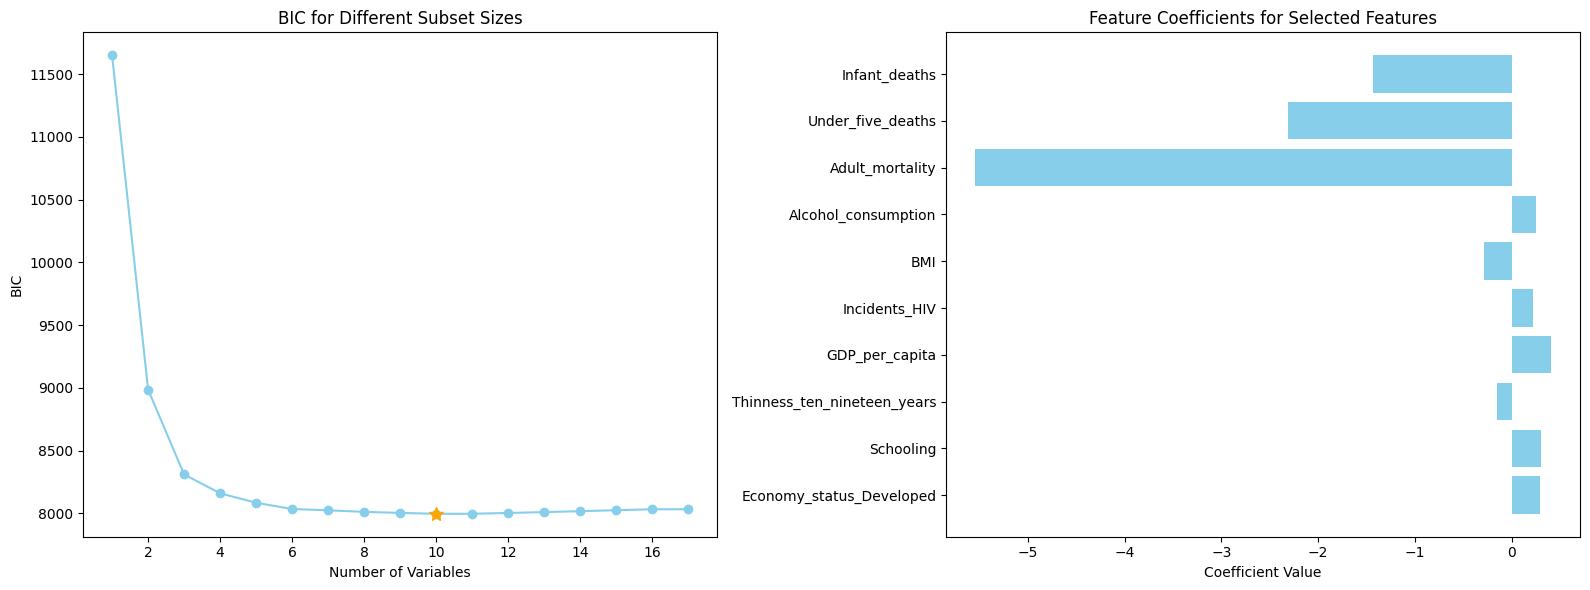

In [35]:
# Step 1: Backward Selection for Subset Selection
model = LinearRegression()
sfs = SFS(model,
          k_features=(1, X_train_og.shape[1]),  # Test from 1 feature up to max features
          forward=False,
          floating=False,
          scoring='r2',
          cv=0)  # Setting cv=0 to get direct estimates without cross-validation for BIC

sfs = sfs.fit(X_train_og, y_train_og)

# Step 2: Calculating BIC for each subset
bic_list = []
n = len(y_train_og)

for subset_size in range(1, X_train_og.shape[1] + 1):  # Loop through all possible subset sizes
    selected_features = list(sfs.subsets_[subset_size]['feature_idx'])  # Get the selected features for each subset size
    X_subset = X_train_og[:, selected_features] 
    
    # Add constant term to the subset (for intercept)
    X_subset_const = add_constant(X_subset)
    
    # Fit OLS model and calculate BIC
    ols_model = OLS(y_train_og, X_subset_const).fit()
    bic_list.append(ols_model.bic)

# Step 3: Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot BIC on the first subplot
ax1.plot(range(1, X_train_og.shape[1] + 1), bic_list, marker='o', linestyle='-', color='skyblue', label='BIC')
ax1.set_xlabel('Number of Variables')
ax1.set_ylabel('BIC')
ax1.set_title('BIC for Different Subset Sizes')

# Mark the minimum BIC point
min_bic_idx = np.argmin(bic_list) + 1  # Index of minimum BIC
ax1.plot(min_bic_idx, bic_list[min_bic_idx - 1], marker='*', markersize=10, color="orange")  # Marking minimum BIC point in red

# Step 4: Plot the selected features in the optimal subset on the second subplot
optimal_features_og_bw = sfs.subsets_[min_bic_idx]['feature_idx']  # Get indices of optimal features

# Fit the model on the optimal subset
X_optimal = X_train_og[:, list(optimal_features_og_bw)]
model.fit(X_optimal, y_train_og)
coefficients = model.coef_
feature_names_og = X_og.columns[list(optimal_features_og_bw)]

# Plotting the coefficients
ax2.barh(feature_names_og, coefficients, color='skyblue')
ax2.set_xlabel('Coefficient Value')
ax2.set_title('Feature Coefficients for Selected Features')
ax2.invert_yaxis()  # Reverse order to have the first selected feature on top

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### _Forward Selection_

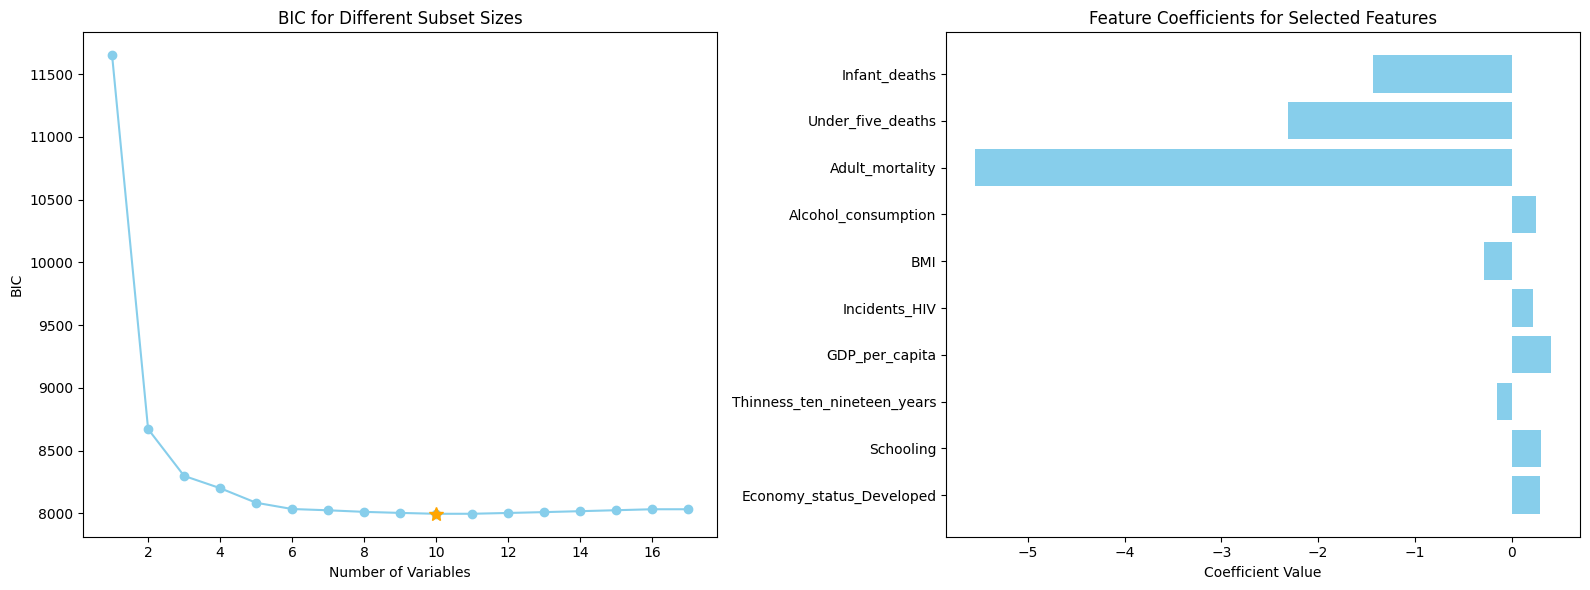

In [36]:
# Step 1: Backward Selection for Subset Selection
model = LinearRegression()
sfs = SFS(model,
          k_features=(1, X_train_og.shape[1]),  # Test from 1 feature up to max features
          forward=True,
          floating=False,
          scoring='r2',
          cv=0)  # Setting cv=0 to get direct estimates without cross-validation for BIC

sfs = sfs.fit(X_train_og, y_train_og)

# Step 2: Calculating BIC for each subset
bic_list = []
n = len(y_train_og)

for subset_size in range(1, X_train_og.shape[1] + 1):  # Loop through all possible subset sizes
    selected_features = list(sfs.subsets_[subset_size]['feature_idx'])  # Get the selected features for each subset size
    X_subset = X_train_og[:, selected_features] 
    
    # Add constant term to the subset (for intercept)
    X_subset_const = add_constant(X_subset)
    
    # Fit OLS model and calculate BIC
    ols_model = OLS(y_train_og, X_subset_const).fit()
    bic_list.append(ols_model.bic)

# Step 3: Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot BIC on the first subplot
ax1.plot(range(1, X_train_og.shape[1] + 1), bic_list, marker='o', linestyle='-', color='skyblue', label='BIC')
ax1.set_xlabel('Number of Variables')
ax1.set_ylabel('BIC')
ax1.set_title('BIC for Different Subset Sizes')

# Mark the minimum BIC point
min_bic_idx = np.argmin(bic_list) + 1  # Index of minimum BIC
ax1.plot(min_bic_idx, bic_list[min_bic_idx - 1], marker='*', markersize=10, color="orange")  # Marking minimum BIC point in red

# Step 4: Plot the selected features in the optimal subset on the second subplot
optimal_features_og_fw = sfs.subsets_[min_bic_idx]['feature_idx']  # Get indices of optimal features
feature_names_og = X_og.columns[list(optimal_features_og_fw)]      # Get names of these features

# Fit the model on the optimal subset
X_optimal = X_train_og[:, list(optimal_features_og_fw)]
model.fit(X_optimal, y_train_og)
coefficients = model.coef_

# Plotting the coefficients
ax2.barh(feature_names_og, coefficients, color='skyblue')
ax2.set_xlabel('Coefficient Value')
ax2.set_title('Feature Coefficients for Selected Features')
ax2.invert_yaxis()  # Reverse order to have the first selected feature on top

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Models

### _Linear Regression_

Min of transformed predictions (y_pred) before inverse Box-Cox: -200744.9482306057
Max of transformed predictions (y_pred) before inverse Box-Cox: 1402917.280146598
NaN values found in inverse transformed predictions for Box-Cox Transformed Data Backward Selection at indices: [150 214 249]
Index 150 was replaced with value: [69.16024764]
Index 214 was replaced with value: [69.16024764]
Index 249 was replaced with value: [69.16024764]
Min of transformed predictions (y_pred) before inverse Box-Cox: -200744.9482306057
Max of transformed predictions (y_pred) before inverse Box-Cox: 1402917.280146598
NaN values found in inverse transformed predictions for Box-Cox Transformed Data Forward Selection at indices: [150 214 249]
Index 150 was replaced with value: [69.16024764]
Index 214 was replaced with value: [69.16024764]
Index 249 was replaced with value: [69.16024764]


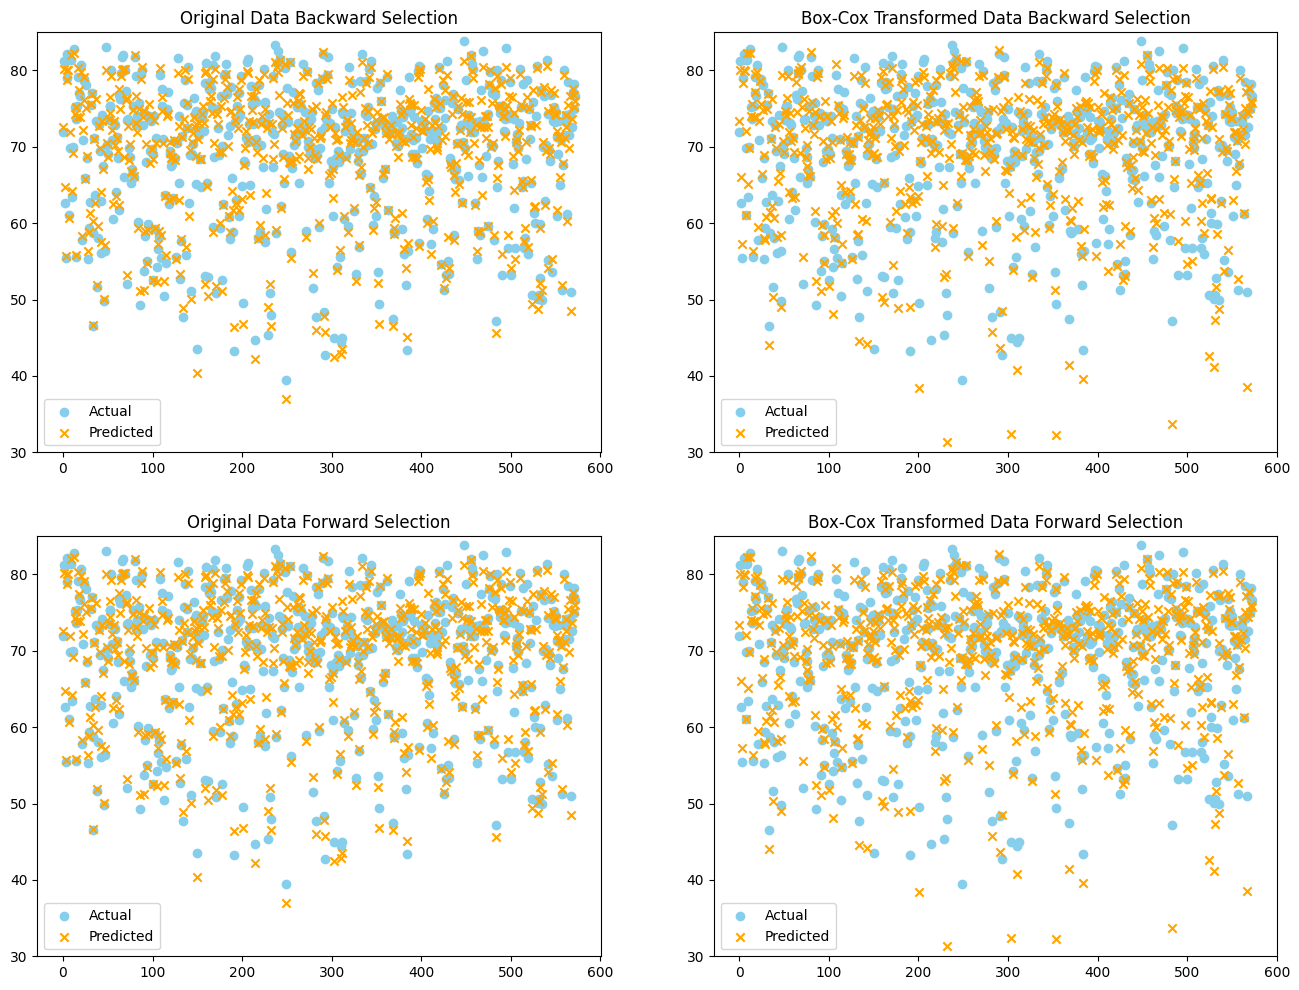

In [37]:
optimal_features = [optimal_features_og_bw, optimal_features_og_fw, optimal_features_tr_bw, optimal_features_tr_fw]
names = ["Original Data Backward Selection", "Original Data Forward Selection", "Box-Cox Transformed Data Backward Selection", "Box-Cox Transformed Data Forward Selection"]

score_table = []

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
i = 0
j = 0

for optimals in optimal_features:
    model = LinearRegression()
    this_X = None
    this_y = None
    y_pred = None
    r_two_score = None

    if "Original" in names[i + j * 2]:
        this_X = X_train_og
        this_X = pd.DataFrame(this_X, columns=X_og.columns)
        this_y = y_train_og
        test_y = y_test_og
        model.fit(this_X.iloc[:, list(optimals)], this_y)

        y_pred = model.predict(X_test_og.iloc[:, list(optimals)])
        r_two_score = model.score(X_test_og.iloc[:, list(optimals)], y_test_og)

    else:
        this_X = X_train
        this_y = y_train
        test_y = y_test
        model.fit(this_X.iloc[:, list(optimals)], y_train)

        y_pred = model.predict(X_test.iloc[:, list(optimals)])
        r_two_score = model.score(X_test.iloc[:, list(optimals)], y_test)

    # Inverse transform predictions and handle NaN values
    if "Transformed" in names[i + j * 2]:
        # Check for small or zero values in y_pred before inverse Box-Cox
        print("Min of transformed predictions (y_pred) before inverse Box-Cox:", np.min(y_pred))
        print("Max of transformed predictions (y_pred) before inverse Box-Cox:", np.max(y_pred))

        # Add a small constant to avoid zero or negative values before inverse transformation
        y_pred_adjusted = y_pred + 1e-6  # Adjust `y_pred` to prevent zero or negative values
        y_test_adjusted = test_y + 1e-6  # Adjust `y_test` to prevent zero or negative values

        # Perform the inverse Box-Cox transformation
        revers_transformed_pred = inv_boxcox(y_pred_adjusted, lambda_val)
        revers_transformed_test = inv_boxcox(y_test_adjusted, lambda_val)

        # Ensure predictions and test values are valid arrays
        revers_transformed_pred = np.array(revers_transformed_pred)
        revers_transformed_test = np.array(revers_transformed_test)

        nan_indices_after = np.where(np.isnan(revers_transformed_pred))[0]
        if len(nan_indices_after) > 0:
            print(f"NaN values found in inverse transformed predictions for {names[i+j*2]} at indices:", nan_indices_after)
            
            # Compute the replacement value
            replacement_value = np.nanmean(revers_transformed_pred)

            # Replace NaN values and print their new values
            revers_transformed_pred = np.nan_to_num(revers_transformed_pred, nan=replacement_value)
            for idx in nan_indices_after:
                print(f"Index {idx} was replaced with value: {revers_transformed_pred[idx]}")
        else:
            print("No NaN values in inverse transformed predictions.")


        # Assign transformed predictions and test data to variables used for further evaluation
        test_y = revers_transformed_test
        y_pred = revers_transformed_pred

    # Save scores in the table
    score_table.append({
        "Model": names[i + j * 2],
        "R² Score": r_two_score,
        "Mean Squared Error (MSE)": mean_squared_error(test_y, y_pred),
        "Mean Absolute Error (MAE)": np.mean(np.abs(test_y - y_pred))
    })

    # Plot the predictions vs actual values
    axes[i, j].scatter(range(0, len(test_y)), test_y, color='skyblue', marker='o')
    axes[i, j].scatter(range(0, len(y_pred)), y_pred, color='orange', marker='x')
    axes[i, j].set_title(names[i+j*2])
    axes[i, j].set_ylim([30, 85])
    labels = ['Actual', 'Predicted']
    axes[i, j].legend(labels)

    # Update loop indices for subplot placement
    i += 1
    if i == 2:
        i = 0
        j += 1

plt.show()


In [38]:
# Convert the score table into a pandas DataFrame for display
score_df = pd.DataFrame(score_table)

# round the scores to 3 decimal places
score_df = score_df.round(3)

score_df.head()

,Model,R² Score,Mean Squared Error (MSE),Mean Absolute Error (MAE)
0,Original Data Backward Selection,0.978,1.857,1.093
1,Original Data Forward Selection,0.978,1.857,1.093
2,Box-Cox Transformed Data Backward Selection,0.947,10.563,9.851
3,Box-Cox Transformed Data Forward Selection,0.947,10.563,9.851


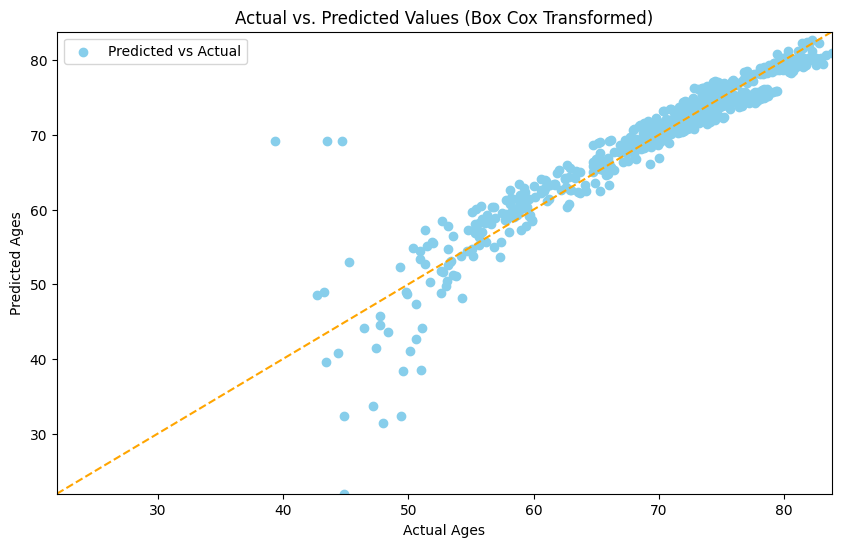

In [39]:
plt.figure(figsize=(10, 6))

# Scatter plot for predicted values vs actual values
plt.scatter(test_y, y_pred, color='skyblue', label='Predicted vs Actual')

plt.title('Actual vs. Predicted Values (Box Cox Transformed)')
plt.xlabel('Actual Ages')
plt.ylabel('Predicted Ages')

# Set the same range for both axes
plt.xlim([min(test_y.min(), y_pred.min()), max(test_y.max(), y_pred.max())])
plt.ylim([min(test_y.min(), y_pred.min()), max(test_y.max(), y_pred.max())])

labels = ['Predicted vs Actual']
plt.legend(labels)

# Plot a diagonal line to represent perfect predictions
plt.plot([min(test_y.min(), y_pred.min()), max(test_y.max(), y_pred.max())], 
         [min(test_y.min(), y_pred.min()), max(test_y.max(), y_pred.max())], linestyle='--', color='orange')

# Show the plot
plt.show()


### _Debugging to try and figure out why we get three indices with nan values_

In [40]:
# Check for small or negative values in y_pred
print("Min of transformed predictions (y_pred) before inverse Box-Cox:", np.min(y_pred))
print("Max of transformed predictions (y_pred) before inverse Box-Cox:", np.max(y_pred))

# Add a small constant to avoid zero or negative values before inverse transformation
y_pred_adjusted = y_pred + 1e-6
revers_transformed_pred = inv_boxcox(y_pred_adjusted, lambda_val)

# Check for NaNs after inverse transformation
nan_indices_after = np.where(np.isnan(revers_transformed_pred))[0]
if len(nan_indices_after) > 0:
    print(f"NaN values found in inverse transformed predictions at indices:", nan_indices_after)
    print("NaN values:", revers_transformed_pred[nan_indices_after])
    
    # Replace NaNs with the mean of valid predictions
    revers_transformed_pred = np.nan_to_num(revers_transformed_pred, nan=np.nanmean(revers_transformed_pred))
else:
    print("No NaN values in inverse transformed predictions.")


Min of transformed predictions (y_pred) before inverse Box-Cox: 21.956666380681966
Max of transformed predictions (y_pred) before inverse Box-Cox: 82.6381958263131
No NaN values in inverse transformed predictions.


In [41]:
# Before applying inverse Box-Cox, check for extreme or problematic values in y_pred
print("Min of transformed predictions (y_pred) before inverse Box-Cox:", np.min(y_pred))
print("Max of transformed predictions (y_pred) before inverse Box-Cox:", np.max(y_pred))

# Find indices of problematic predictions (e.g., negative values or too large)
problematic_indices = np.where(y_pred < 0)[0]  # You can also check for extreme large values, e.g., y_pred > threshold
if len(problematic_indices) > 0:
    print("Problematic indices (negative values in y_pred):", problematic_indices)
    print("Problematic predictions:", y_pred[problematic_indices])

# Add a small constant to avoid zero or negative values before inverse transformation
y_pred_adjusted = y_pred + 1e-6
test_y_adjusted = test_y + 1e-6  # Adjust test_y similarly if needed

# Perform inverse Box-Cox transformation
revers_transformed_pred = inv_boxcox(y_pred_adjusted, lambda_val)

# After inverse transformation, check for NaN values and print indices
nan_indices_after = np.where(np.isnan(revers_transformed_pred))[0]
if len(nan_indices_after) > 0:
    print(f"NaN values found in inverse transformed predictions at indices:", nan_indices_after)
    print("NaN values:", revers_transformed_pred[nan_indices_after])

    # print the actual problematic rows from the dataset (before transformation)
    print("Problematic rows from the dataset:")
    print(df.iloc[nan_indices_after])  # Assuming 'df' is your DataFrame, print the problematic rows
else:
    print("No NaN values in inverse transformed predictions.")

# You can also check if extreme predictions cause problems after inverse transformation
extreme_values = np.where(revers_transformed_pred > 1e6)[0]  # Define an appropriate threshold for extreme values
if len(extreme_values) > 0:
    print(f"Extreme values found at indices:", extreme_values)
    print("Extreme predictions:", revers_transformed_pred[extreme_values])


Min of transformed predictions (y_pred) before inverse Box-Cox: 21.956666380681966
Max of transformed predictions (y_pred) before inverse Box-Cox: 82.6381958263131
No NaN values in inverse transformed predictions.


### _Random Forest_

#### Best subset from forward selection

In [42]:
# Transformed data
optimal_features_tr_fw = sfs.subsets_[min_bic_idx]['feature_idx']  # Get indices of optimal features
feature_names_og = X.columns[list(optimal_features_tr_fw)]  # Get names of these features
X_optimal_tr = X_train.iloc[:, list(optimal_features_tr_fw)]  # Optimal features from training set
X_optimal_test = X_test.iloc[:, list(optimal_features_tr_fw)]  # Test set with optimal features

# Original data
optimal_features_og_fw = sfs.subsets_[min_bic_idx]['feature_idx']  # Get indices of optimal features
feature_names_og = X_og.columns[list(optimal_features_og_fw)]  # Get names of these features

# Subset the test data with the optimal features
X_optimal_test_og = X_test_og.iloc[:, list(optimal_features_og_fw)]  # Test set with optimal features

#### Model

/Users/inamartini/Desktop/skole/H2024/maskinlæring/oving_2/pythonProject/.venv/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/inamartini/Desktop/skole/H2024/maskinlæring/oving_2/pythonProject/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


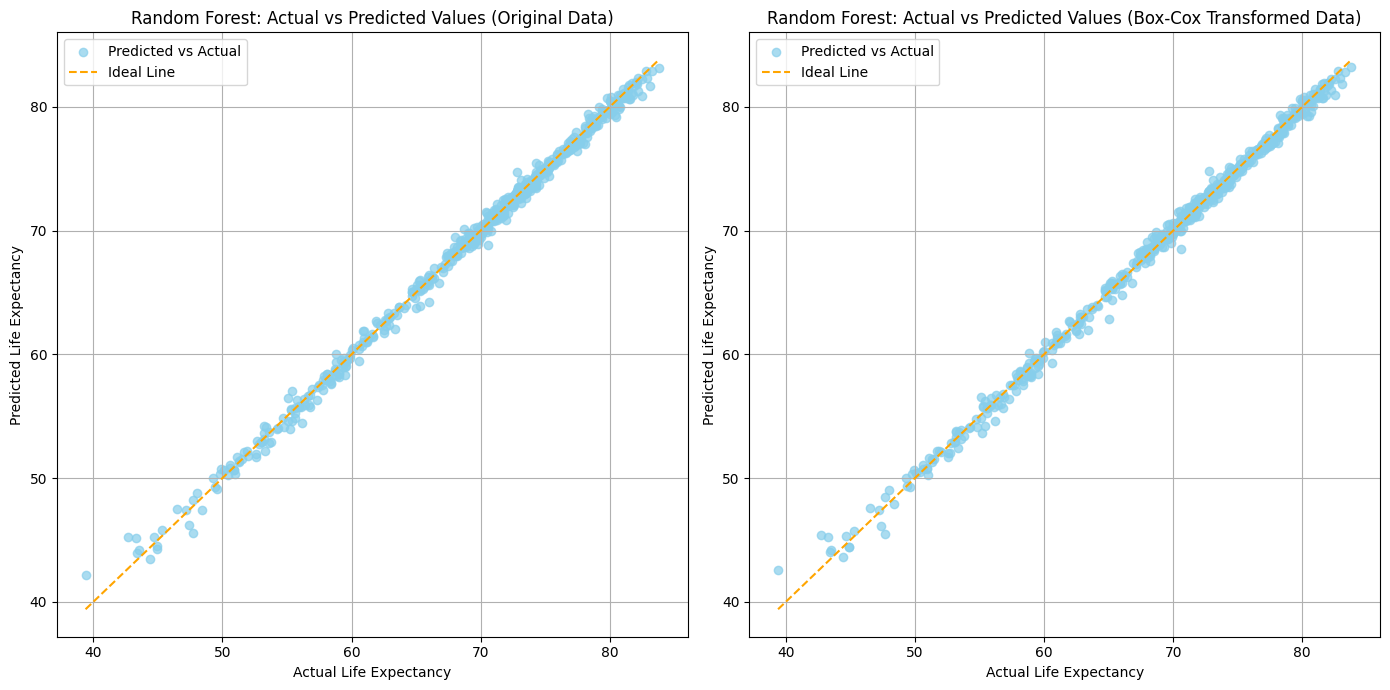

In [43]:
# Random forest on the transformed data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_optimal_tr, y_train)  # Train on the training set

# Generate predictions on the test set
y_pred_rf = rf_model.predict(X_optimal_test)  # Predict on the test set

# Random forest on the original data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_optimal, y_train_og)  # Train on the training set

# Generate predictions on the test set
y_pred_rf_og = rf_model.predict(X_optimal_test_og)  # Predict on the test set


# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# For the transformed (Box-Cox transformed) data
y_test_inv = inv_boxcox(y_test, lambda_val)
y_pred_rf_inv = inv_boxcox(y_pred_rf, lambda_val)

# First plot: Actual vs Predicted for the first model (y_test_og vs y_pred_rf_og)
ax1.scatter(y_test_og, y_pred_rf_og, color='skyblue', label='Predicted vs Actual', alpha=0.7)
ax1.plot([min(y_test_og), max(y_test_og)], [min(y_test_og), max(y_test_og)], color='orange', linestyle='--', label='Ideal Line')
ax1.set_title('Random Forest: Actual vs Predicted Values (Original Data)')
ax1.set_xlabel('Actual Life Expectancy')
ax1.set_ylabel('Predicted Life Expectancy')
ax1.legend()
ax1.grid(True)

# Second plot: Actual vs Predicted for the second model (y_test vs y_pred_rf)
ax2.scatter(y_test_inv, y_pred_rf_inv, color='skyblue', label='Predicted vs Actual', alpha=0.7)
ax2.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], color='orange', linestyle='--', label='Ideal Line')
ax2.set_title('Random Forest: Actual vs Predicted Values (Box-Cox Transformed Data)')
ax2.set_xlabel('Actual Life Expectancy')
ax2.set_ylabel('Predicted Life Expectancy')
ax2.legend()
ax2.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


In [44]:
# Calculate the R², MSE and MAE score for the Random Forest model 
r2_rf = r2_score(y_test_og, y_pred_rf_og)
mse_rf = mean_squared_error(y_test_og, y_pred_rf_og)
mae_rf = mean_absolute_error(y_test_og, y_pred_rf_og)

score_table = []

# Save scores in the table
score_table.append({
    "Model": "Random Forest on Original Data",
    "R² Score": r2_rf,
    "Mean Squared Error (MSE)": mse_rf,
    "Mean Absolute Error (MAE)": mae_rf
})

# Convert the score table into a pandas DataFrame for display
score_df = pd.DataFrame(score_table)

# round the scores to 3 decimal places
score_df = score_df.round(4)

score_df.head()


,Model,R² Score,Mean Squared Error (MSE),Mean Absolute Error (MAE)
0,Random Forest on Original Data,0.9966,0.284,0.3853


In [45]:
# Calculate the R², MSE and MAE score for the Random Forest model on transformed data
r2_rf_tr = r2_score(y_test, y_pred_rf)
mse_rf_tr = mean_squared_error(y_test_inv, y_pred_rf_inv)
mae_rf_tr = mean_absolute_error(y_test_inv, y_pred_rf_inv)

score_table_tr = []

# Save scores in the table
score_table_tr.append({
    "Model": "Random Forest on Transformed Data",
    "R² Score": r2_rf_tr,
    "Mean Squared Error (MSE)": mse_rf_tr,
    "Mean Absolute Error (MAE)": mae_rf_tr
})

# Convert the score table into a pandas DataFrame for display
score_df_tr = pd.DataFrame(score_table_tr)

# round the scores to 3 decimal places
score_df_tr = score_df_tr.round(4)

score_df_tr.head()

,Model,R² Score,Mean Squared Error (MSE),Mean Absolute Error (MAE)
0,Random Forest on Transformed Data,0.9963,0.2859,0.3818


### _K Nearest Neighbour_

#### Finding the best n

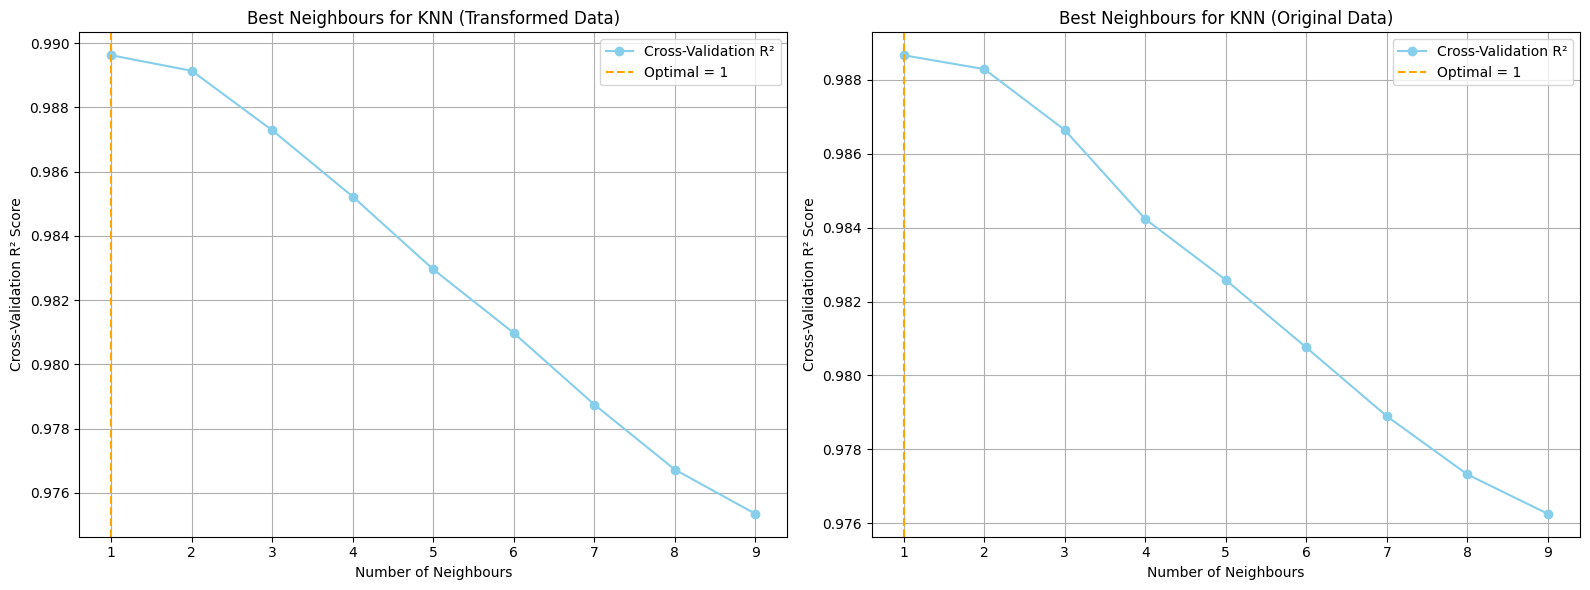

In [46]:
# Initialize subplots for side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# First: Evaluate and plot for transformed data
neighbor_range = range(1, 10)
cv_scores_transformed = []

for n in neighbor_range:
    knn = KNeighborsRegressor(n_neighbors=n)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='r2')
    cv_scores_transformed.append(scores.mean())

best_n_neighbors_transformed = neighbor_range[np.argmax(cv_scores_transformed)]

# Plot for transformed data
ax1.plot(neighbor_range, cv_scores_transformed, marker='o', linestyle='-', color='skyblue', label="Cross-Validation R²")
ax1.axvline(best_n_neighbors_transformed, color='orange', linestyle='--',
            label=f"Optimal = {best_n_neighbors_transformed}")
ax1.set_title("Best Neighbours for KNN (Transformed Data)")
ax1.set_xlabel("Number of Neighbours")
ax1.set_ylabel("Cross-Validation R² Score")
ax1.legend()
ax1.grid()

# Second: Evaluate and plot for original data
cv_scores_original = []

for n in neighbor_range:
    knn = KNeighborsRegressor(n_neighbors=n)
    scores = cross_val_score(knn, X_train_og, y_train_og, cv=5, scoring='r2')
    cv_scores_original.append(scores.mean())

best_n_neighbors_original = neighbor_range[np.argmax(cv_scores_original)]

# Plot for original data
ax2.plot(neighbor_range, cv_scores_original, marker='o', linestyle='-', color='skyblue', label="Cross-Validation R²")
ax2.axvline(best_n_neighbors_original, color='orange', linestyle='--',
            label=f"Optimal = {best_n_neighbors_original}")
ax2.set_title("Best Neighbours for KNN (Original Data)")
ax2.set_xlabel("Number of Neighbours")
ax2.set_ylabel("Cross-Validation R² Score")
ax2.legend()
ax2.grid()

# Adjust layout and show
plt.tight_layout()
plt.show()


#### Model

/Users/inamartini/Desktop/skole/H2024/maskinlæring/oving_2/pythonProject/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


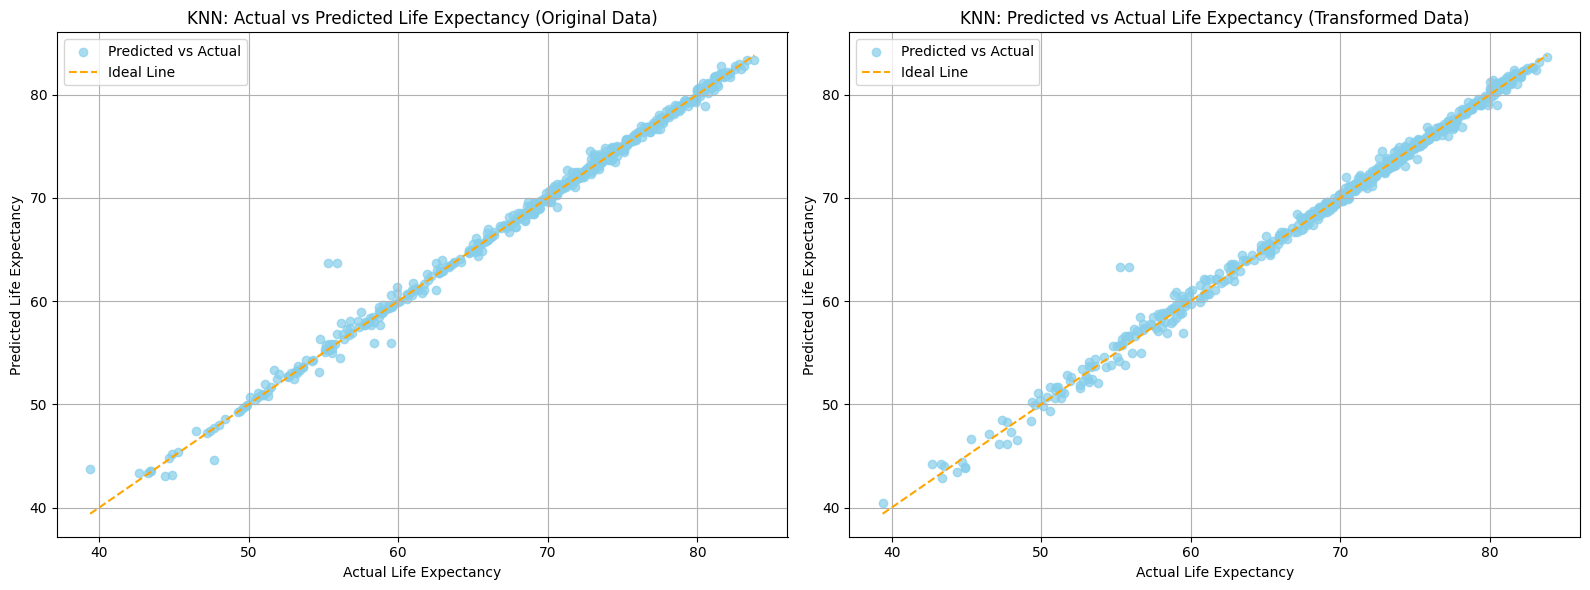

In [47]:
# Train KNN Model on transformed data
# Create KNN regressor with a chosen number of neighbors
knn_model = KNeighborsRegressor(n_neighbors=1)

# Train KNN model on the training set with optimal features
knn_model.fit(X_optimal_tr, y_train)

# Generate Predictions
y_pred_knn = knn_model.predict(X_optimal_test)

# For the transformed (Box-Cox transformed) data
y_test_inv = inv_boxcox(y_test, lambda_val)
y_pred_knn_inv = inv_boxcox(y_pred_knn, lambda_val)


# Train KNN Model on original data
knn_model_og = KNeighborsRegressor(n_neighbors=2)

# Train KNN model on the training set with optimal features
knn_model_og.fit(X_optimal, y_train_og)

# Generate Predictions
y_pred_knn_og = knn_model_og.predict(X_optimal_test_og)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  

# First plot: Actual vs Predicted for the first model (y_test_og vs y_pred_knn_og)
ax1.scatter(y_test_og, y_pred_knn_og, color='skyblue', label='Predicted vs Actual', alpha=0.7)
ax1.plot([min(y_test_og), max(y_test_og)], [min(y_test_og), max(y_test_og)], color='orange', linestyle='--', label='Ideal Line')
ax1.set_title('KNN: Actual vs Predicted Life Expectancy (Original Data)')
ax1.set_xlabel('Actual Life Expectancy')
ax1.set_ylabel('Predicted Life Expectancy')
ax1.legend()
ax1.grid(True)

# Second plot: Actual vs Predicted for the second model (y_test vs y_pred_knn)
ax2.scatter(y_test_inv, y_pred_knn_inv, color='skyblue', label='Predicted vs Actual', alpha=0.7)
ax2.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], color='orange', linestyle='--', label='Ideal Line')
ax2.set_title("KNN: Predicted vs Actual Life Expectancy (Transformed Data)")
ax2.set_xlabel("Actual Life Expectancy")
ax2.set_ylabel("Predicted Life Expectancy")
ax2.legend()
ax2.grid(True)
plt.tight_layout()

plt.show()


In [48]:
# Step 3: Evaluate the KNN Model on the original data
r2_knn_og = r2_score(y_test_og, y_pred_knn_og)
mse_knn_og = mean_squared_error(y_test_og, y_pred_knn_og)
mae_knn_og = mean_absolute_error(y_test_og, y_pred_knn_og)

score_table_knn_og = []

# Save scores in the table
score_table_knn_og.append({
    "Model": "KNN on Original Data",
    "R² Score": r2_knn_og,
    "Mean Squared Error (MSE)": mse_knn_og,
    "Mean Absolute Error (MAE)": mae_knn_og
})

# Convert the score table into a pandas DataFrame for display
score_df_knn_og = pd.DataFrame(score_table_knn_og)

# round the scores to 3 decimal places
score_df_knn_og = score_df_knn_og.round(4)

score_df_knn_og.head()

,Model,R² Score,Mean Squared Error (MSE),Mean Absolute Error (MAE)
0,KNN on Original Data,0.9941,0.4856,0.3166


In [49]:
# Step 3: Evaluate the KNN Model on the transformed data
r2_knn_tr = r2_score(y_test_inv, y_pred_knn_inv)
mse_knn_tr = mean_squared_error(y_test_inv, y_pred_knn_inv)
mae_knn_tr = mean_absolute_error(y_test_inv, y_pred_knn_inv)

score_table_knn_tr = []

# Save scores in the table
score_table_knn_tr.append({
    "Model": "KNN on Transformed Data",
    "R² Score": r2_knn_tr,
    "Mean Squared Error (MSE)": mse_knn_tr,
    "Mean Absolute Error (MAE)": mae_knn_tr
})

# Convert the score table into a pandas DataFrame for display
score_df_knn_tr = pd.DataFrame(score_table_knn_tr)

# round the scores to 3 decimal places
score_df_knn_tr = score_df_knn_tr.round(4)

score_df_knn_tr.head()


,Model,R² Score,Mean Squared Error (MSE),Mean Absolute Error (MAE)
0,KNN on Transformed Data,0.9938,0.5117,0.4482


### _Linear Regression_

Index 150 was replaced with value: [69.15714831]
Index 214 was replaced with value: [69.15714831]
Index 249 was replaced with value: [69.15714831]


/Users/inamartini/Desktop/skole/H2024/maskinlæring/oving_2/pythonProject/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


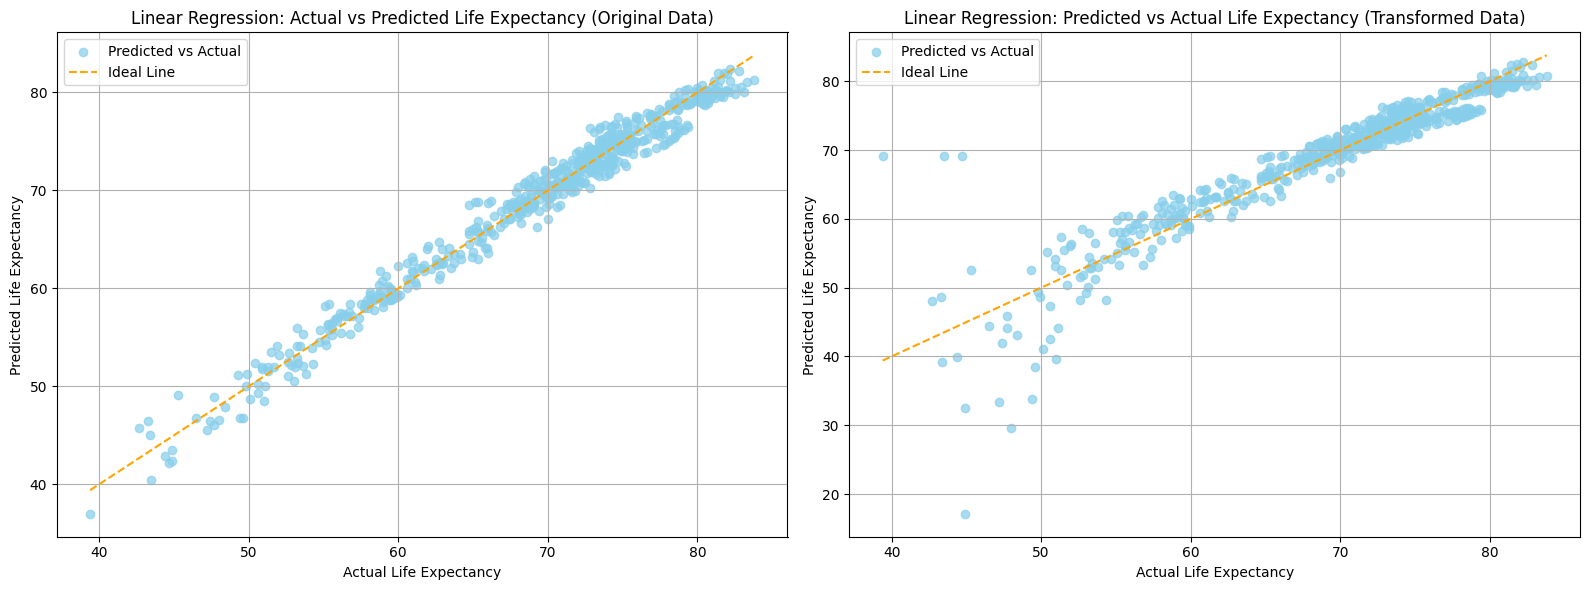

In [50]:
# Linear Regression on Transformed Data
# Train a linear regression model on the training set with optimal features
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_optimal_tr, y_train)  # Train on transformed data

# Generate Predictions
y_pred_lr = lin_reg_model.predict(X_optimal_test)

# For the transformed (Box-Cox transformed) data
y_test_inv = inv_boxcox(y_test, lambda_val)
y_pred_lr_inv = inv_boxcox(y_pred_lr, lambda_val)

# handle NaN values in the inverse transformed predictions
nan_indices_after = np.where(np.isnan(y_pred_lr_inv))[0]
if len(nan_indices_after) > 0:
    # Compute the replacement value
    replacement_value = np.nanmean(y_pred_lr_inv)

    # Replace NaN values and print their new values
    revers_transformed_pred = np.nan_to_num(y_pred_lr_inv, nan=replacement_value)
    revers_transformed_test = np.nan_to_num(y_test_inv, nan=replacement_value)
    for idx in nan_indices_after:
        print(f"Index {idx} was replaced with value: {revers_transformed_pred[idx]}")
else:
    print("No NaN values in inverse transformed predictions.")

y_pred_lr_inv = revers_transformed_pred
y_test_inv = revers_transformed_test

# Linear Regression on Original Data
lin_reg_model_og = LinearRegression()
lin_reg_model_og.fit(X_optimal, y_train_og)  # Train on original data

# Generate Predictions
y_pred_lr_og = lin_reg_model_og.predict(X_optimal_test_og)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# First plot: Actual vs Predicted for the first model (y_test_og vs y_pred_lr_og)
ax1.scatter(y_test_og, y_pred_lr_og, color='skyblue', label='Predicted vs Actual', alpha=0.7)
ax1.plot([min(y_test_og), max(y_test_og)], [min(y_test_og), max(y_test_og)], color='orange', linestyle='--', label='Ideal Line')
ax1.set_title('Linear Regression: Actual vs Predicted Life Expectancy (Original Data)')
ax1.set_xlabel('Actual Life Expectancy')
ax1.set_ylabel('Predicted Life Expectancy')
ax1.legend()
ax1.grid(True)

# Second plot: Actual vs Predicted for the second model (y_test vs y_pred_lr)
ax2.scatter(y_test_inv, y_pred_lr_inv, color='skyblue', label='Predicted vs Actual', alpha=0.7)
ax2.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], color='orange', linestyle='--', label='Ideal Line')
ax2.set_title("Linear Regression: Predicted vs Actual Life Expectancy (Transformed Data)")
ax2.set_xlabel("Actual Life Expectancy")
ax2.set_ylabel("Predicted Life Expectancy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [51]:
# Step 3: Evaluate the Linear Regression Model on the original data
r2_lr_og = r2_score(y_test_og, y_pred_lr_og)
mse_lr_og = mean_squared_error(y_test_og, y_pred_lr_og)
mae_lr_og = mean_absolute_error(y_test_og, y_pred_lr_og)

score_table_lr_og = []

# Save scores in the table
score_table_lr_og.append({
    "Model": "Linear Regression on Original Data",
    "R² Score": r2_lr_og,
    "Mean Squared Error (MSE)": mse_lr_og,
    "Mean Absolute Error (MAE)": mae_lr_og
})

# Convert the score table into a pandas DataFrame for display
score_df_lr_og = pd.DataFrame(score_table_lr_og)

# round the scores to 3 decimal places
score_df_lr_og = score_df_lr_og.round(4)

score_df_lr_og.head()

,Model,R² Score,Mean Squared Error (MSE),Mean Absolute Error (MAE)
0,Linear Regression on Original Data,0.9776,1.8572,1.0934


In [52]:
# Step 3: Evaluate the KNN Model on the original data
r2_lr_tr = r2_score(y_test_inv, y_pred_lr_inv)
mse_lr_tr = mean_squared_error(y_test_inv, y_pred_lr_inv)
mae_lr_tr = mean_absolute_error(y_test_inv, y_pred_lr_inv)

score_table_lr_tr = []

# Save scores in the table
score_table_lr_tr.append({
    "Model": "Linear Regression on Transformed Data",
    "R² Score": r2_lr_tr,
    "Mean Squared Error (MSE)": mse_lr_tr,
    "Mean Absolute Error (MAE)": mae_lr_tr
})

# Convert the score table into a pandas DataFrame for display
score_df_lr_tr = pd.DataFrame(score_table_lr_tr)

# round the scores to 3 decimal places
score_df_lr_tr = score_df_lr_tr.round(4)

score_df_lr_tr.head()

,Model,R² Score,Mean Squared Error (MSE),Mean Absolute Error (MAE)
0,Linear Regression on Transformed Data,0.8669,11.0431,1.8283
